In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
with open('data/train.json') as f:
    data = json.load(f)

# Flatten the data: combine all cases from all years into a single list
all_cases = []
for year, cases in data.items():
    for case in cases:
        case['year'] = year  # Add year info to each case
        all_cases.append(case)

# Convert to DataFrame
df = pd.DataFrame(all_cases)

# Now you can explore the DataFrame
print(df.columns)

Index(['year', 'docket', 'case_name', 'links', 'written_opinion',
       'transcripts', 'Summary'],
      dtype='object')


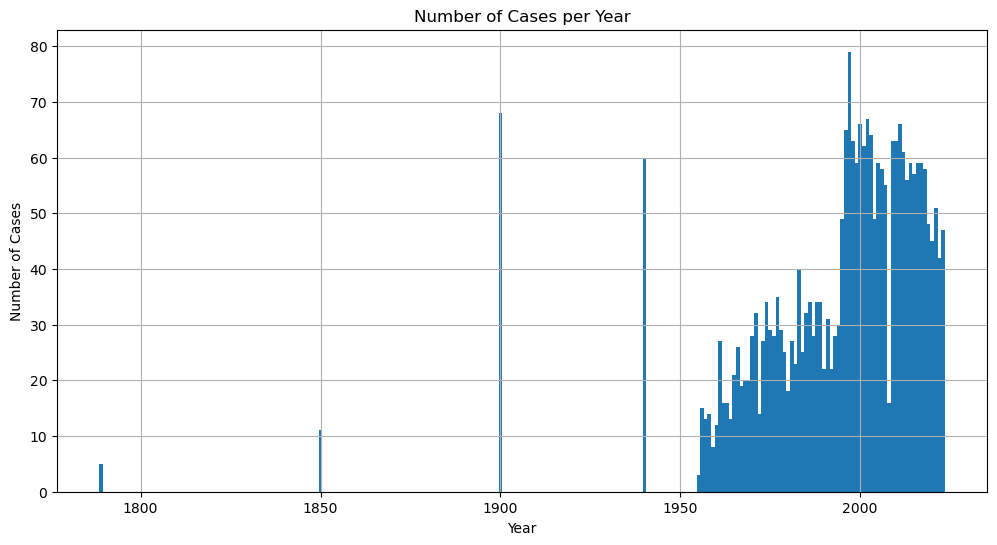

In [52]:
# histogram with the number of cases per year
def extract_start_year(y):
	# If year is a range like '1900-1940', take the first part
	if '-' in str(y):
		return int(str(y).split('-')[0])
	else:
		return int(y)

df['year_int'] = df['year'].apply(extract_start_year)
df['year_int'].hist(bins=np.arange(1789, 2025)-0.5, figsize=(12,6))
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.title('Number of Cases per Year')
plt.show()

In [3]:
def count_words(text):
    if not isinstance(text, str):
        return 0
    return len(text.split())

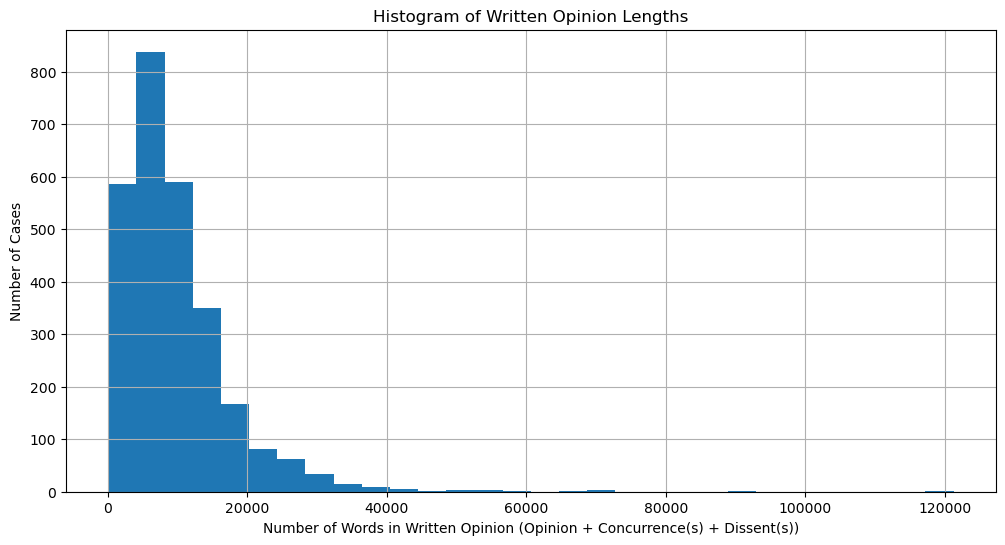

In [ ]:
all_cases = []
for year, cases in data.items():
    for case in cases:
        parsed = case.get('written_opinion', {}).get('parsed', {})
        # Concatenate all opinion texts except 'conclusion'
        opinion_texts = []
        for key, value in parsed.items():
            if key.lower() != 'conclusion' and key.lower() != 'syllabus' and isinstance(value, str):
                opinion_texts.append(value)
        full_text = " ".join(opinion_texts)
        case['parsed_word_count'] = count_words(full_text)
        all_cases.append(case)

df_word_count = pd.DataFrame(all_cases)

# Plot histogram of word counts
df_word_count['parsed_word_count'].hist(bins=30, figsize=(12,6))
plt.xlabel('Number of Words in Written Opinion (Opinion + Concurrence(s) + Dissent(s))')
plt.ylabel('Number of Cases')
plt.title('Histogram of Written Opinion Lengths')
plt.show()

In [49]:
all_opinions = []
all_conclusions = []
total_opinion_words = 0
total_conclusion_words = 0
res = 0
for year, cases in data.items():
    for case in cases:
        parsed = case.get('written_opinion', {}).get('parsed', {})
        conclusion = case.get('Summary', {}).get('conclusion', '')
        opinion_texts = []
        for key, value in parsed.items():
            if key.lower() != 'conclusion' and key.lower() != 'syllabus' and isinstance(value, str):
                opinion_texts.append(value)
        full_text = " ".join(opinion_texts)
        words_in_opinion = count_words(full_text)
        words_in_conclusion = count_words(conclusion)
        total_opinion_words += words_in_opinion
        total_conclusion_words += words_in_conclusion
        if words_in_opinion <= words_in_conclusion:
            res += 1

print(total_opinion_words, total_conclusion_words)
print(f"Average opinion length: {total_opinion_words / len(df)} words")
print(f"Average conclusion length: {total_conclusion_words / len(df)} words")
print(res)

26976827 440286
Average opinion length: 9788.398766328011 words
Average conclusion length: 159.755442670537 words
1


# Traitement du dataset

In [37]:
with open('data/train.json') as f:
    data = json.load(f)

all_cases = []
for year, cases in data.items():
    for case in cases:
        year1, year2 = year.split('-') if '-' in year else (year, year)
        case['year'] = (int(year1) + int(year2)) // 2  # Average year if it's a range (ex: 1900-1940)
        all_cases.append(case)

df = pd.DataFrame(all_cases)

# Remove duplicates based on 'links' column
print(f"Number of duplicate URLs: {df['links'].duplicated().sum()}")
df = df.drop_duplicates(subset=['links'], keep='first')
print(f"Number of cases after removing duplicates: {len(df)}")

# Reset index to have consecutive indices from 0 to len(df)-1
df = df.reset_index(drop=True)

Number of duplicate URLs: 36
Number of cases after removing duplicates: 2720


In [43]:
to_remove = []
for i, row in df.iterrows():
    parsed = row['written_opinion']['parsed']
    summary = row['Summary']
    nb_words_opinion = 0
    nb_words_summary = 0
    for _, value in parsed.items():
        nb_words_opinion += len(value)
    for _, value in summary.items():
        nb_words_summary += len(value)
    if nb_words_opinion < nb_words_summary:
        to_remove.append(i)
        print(f"Case n°{i}, year {row['year']}")
        print_text(i)
        print(row['links'])
        print("####################################################################")
print(f"Number of cases where summary is longer than opinion: {len(to_remove)}")
print(to_remove)

Case n°17, year 2013
Per curiam: NOTICE: This opinion is subject to formal revision before publication in the preliminary print of the United States Reports. Readers are requested to notify the Reporter of Decisions, Supreme Court of the United States, Washington, D. C. 20543, of any typographical or other formal errors, in order that corrections may be made before the preliminary print goes to press. SUPREME COURT OF THE UNITED STATES _________________ No. 12–872 _________________ LISA MADIGAN, et al., PETITIONERS v. HARVEY N. LEVIN on writ of certiorari to the united states court of appeals for the seventh circuit [October 15, 2013] Per Curiam. The writ of certiorari is dismissed as improvidently granted. It is so ordered.

701
-------------------------------
facts_of_the_case: Harvey N. Levin was hired as an Illinois Assistant District Attorney on September 5, 2000. On May 12, 2006 when he was fired, Levin was over the age of sixty, and he believed that he was fired due to his age a

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2720 entries, 0 to 2755
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   year             2720 non-null   int64 
 1   docket           2720 non-null   object
 2   case_name        2720 non-null   object
 3   links            2720 non-null   object
 4   written_opinion  2720 non-null   object
 5   transcripts      2720 non-null   object
 6   Summary          2720 non-null   object
dtypes: int64(1), object(6)
memory usage: 170.0+ KB


In [33]:
def print_text(x):
    for key, value in df.iloc[x]['written_opinion']['parsed'].items():
        print(f"{key}: {value}\n")
        print(len(value))
    print("-------------------------------")
    for key, value in df.iloc[x]['Summary'].items():
        print(f"{key}: {value}\n")
        print(len(value))
print_text(77)


Case: U.S. Supreme Court KOEHLER v. ENGLE, 466 U.S. 1 (1984) 466 U.S. 1 KOEHLER, WARDEN v. ENGLE CERTIORARI TO THE UNITED STATES COURT OF APPEALS FOR THE SIXTH CIRCUIT No. 83-1. Argued February 28, 1984 Decided March 26, 1984 707 F.2d 241, affirmed by an equally divided Court. Louis J. Caruso, Solicitor General of Michigan, argued the cause for petitioner. With him on the brief were Frank J. Kelley, Attorney General, and Thomas C. Nelson, Assistant Attorney General. John Nussbaumer argued the cause and filed a brief for respondent. PER CURIAM. The judgment is affirmed by an equally divided Court. JUSTICE MARSHALL took no part in the decision of this case. Page 466 U.S. 1, 2

676
syllabus: Syllabus U.S. Supreme Court KOEHLER v. ENGLE, 466 U.S. 1 (1984) 466 U.S. 1 KOEHLER, WARDEN v. ENGLE CERTIORARI TO THE UNITED STATES COURT OF APPEALS FOR THE SIXTH CIRCUIT No. 83-1. Argued February 28, 1984 Decided March 26, 1984 707 F.2d 241 , affirmed by an equally divided Court. Louis J. Caruso, Sol

In [51]:

df.iloc[2650]['links']

{'justia': 'https://supreme.justia.com/cases/federal/us/400/74/',
 'oyez': 'https://api.oyez.org/cases/1969/10'}

In [94]:
def regroup(dic):
    if not isinstance(dic, dict):
        return ""
    parsed = dic.get('parsed', {})
    opinion_texts = []
    for _, value in parsed.items():
        opinion_texts.append(value)
    full_text = " ".join(opinion_texts)
    return full_text

df['whole_opinion'] = df['written_opinion'].apply(lambda x: regroup(x))


# Stats

Nombre de cases : 2756

Date de 1789 à 2024

Majorité des cases a partir des années 1970 environ

Très grande majorité des cas entre 0 et 20000 mots, moyenne a environ 10 000 mots, moyenne de la conclusion à 160 mots
# Questions a poser
Est ce que c'est pertinent de prendre en compte le syllabus

Est ce que par défaut on dégage ce qui n'a pas trop de sens, comme par exemple le fait que certaines affaires n'ont pas vraiment de résumé, et du coup on a que très peu de valeur dedans ?